### Features importance:
- This file might be repetable but, it is just to focus on one model that can be defined manuallty. It is only for XGBRegressor, you can change the models If you want.
- The data used is mainly for **Houses and Apartments combined without outliers**

In [1]:
# changing the working directory 
import os
print("Current working directory:", os.getcwd()) 
os.chdir("C:/Users/mgabi/Desktop/immo-eliza-ml") ############ specify your working directory ############

Current working directory: c:\Users\mgabi\Desktop\immo-eliza-ml\Notebooks


In [2]:

import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [3]:
#################### Cleaning ####################
def cleaning(dataset):
# droping empty rows 
    dataset.dropna(subset=['total_area_sqm','terrace_sqm','garden_sqm','nbr_frontages','equipped_kitchen'], inplace=True)
    dataset = dataset[dataset['nbr_bedrooms'] != 0]
    #  Filling the missing data 
    dataset['total_area_sqm'] = dataset['total_area_sqm'].fillna(dataset['total_area_sqm'].mean())  # ---> filling total_area_sqm with mean
    dataset['construction_year'] = dataset['construction_year'].fillna(dataset['construction_year'].mode()) # ---> filling construction_year with median
    dataset['nbr_bedrooms'] = dataset['nbr_bedrooms'].fillna(dataset['nbr_bedrooms'].mean()) # ---> filling nbr_bedrooms with mean
    dataset['equipped_kitchen'] = dataset['equipped_kitchen'].replace(0, 'unknown').fillna('unknown')
    dataset['state_building'] = dataset['state_building'].replace(0, 'unknown').fillna('unknown')
    dataset['nbr_frontages'] = dataset['nbr_frontages'].fillna(dataset['nbr_frontages'].median())
    dataset['epc'] = dataset['epc'].fillna(dataset['epc'].mode()[0])  #--> Filling with the most frequent 
    dataset['garden_sqm'] = dataset['garden_sqm'].fillna(dataset['garden_sqm'].mean())  #--> Filling with the most frequent 
    dataset['surface_land_sqm'] = dataset['surface_land_sqm'].fillna(dataset['surface_land_sqm'].median())
    
    return dataset
def enccoding(dataset):
#################### Encoding ####################
    kitchen_order = ['unknown','NOT_INSTALLED',"USA_UNINSTALLED", "SEMI_EQUIPPED","USA_SEMI_EQUIPPED", "INSTALLED","USA_INSTALLED","HYPER_EQUIPPED","USA_HYPER_EQUIPPED" ]
    building_con_order = ['unknown',"TO_RESTORE", "TO_RENOVATE", "TO_BE_DONE_UP", "GOOD", "JUST_RENOVATED", "AS_NEW"]
    epc_order = ['G','F','E','D','C','B','A','A+','A++' ] 
    encoder_kit = OrdinalEncoder(categories=[kitchen_order])
    encoder_bul = OrdinalEncoder(categories=[building_con_order])
    encoder_epc = OrdinalEncoder(categories=[epc_order])
    dataset['kitchen_type_encoded'] = encoder_kit.fit_transform(dataset[['equipped_kitchen']])
    dataset['Bulding_sta_encoded'] = encoder_bul.fit_transform(dataset[['state_building']])
    dataset['epc_encoded'] = encoder_epc.fit_transform(dataset[['epc']])
    # Encode 'locality' using OneHotEncoder
    locality_encoder = OneHotEncoder(sparse_output=False, drop='first')
    locality_encoded = locality_encoder.fit_transform(dataset[['locality']])
    locality_encoded_df = pd.DataFrame(locality_encoded, columns=locality_encoder.get_feature_names_out(['locality']))
    dataset = pd.concat([dataset.reset_index(drop=True), locality_encoded_df.reset_index(drop=True)], axis=1)
    return dataset,locality_encoded_df.columns.tolist()

def evaluate_models(X_train, X_test, y_train, y_test, models):
    results = {}

    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train, y_train)  # Train the model
        predictions = model.predict(X_test)  # Make predictions on the test set

        # Calculate evaluation metrics
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mae)
        r2 = r2_score(y_test, predictions)

        # Store the metrics
        results[name] = {
            "MAE": mae,
            "R²": r2,
            "Train Score": train_score,
            "Test Score": test_score,
            "Model name": name,
            "RMSE" : rmse
        }


    results_df = pd.DataFrame(results).T
    return results_df

    


C:\Users\mgabi\AppData\Local\Temp\ipykernel_25772\2988921123.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['total_area_sqm'] = dataset['total_area_sqm'].fillna(dataset['total_area_sqm'].mean())  # ---> filling total_area_sqm with mean
C:\Users\mgabi\AppData\Local\Temp\ipykernel_25772\2988921123.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['construction_year'] = dataset['construction_year'].fillna(dataset['construction_year'].mode()) # ---> filling construction_year with median
C

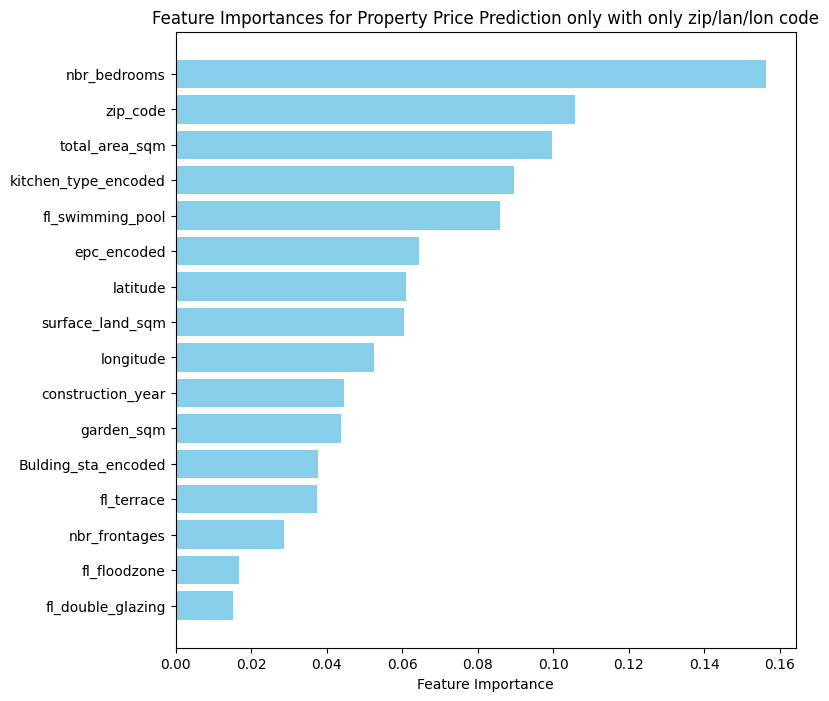

In [4]:
#####################################  feature importances #####################################
dataset = pd.read_csv(r"Results and Evaluation\Houses_and_Apartments_combined_without_outliers.csv") 
dataset, locality_encoded_columns = enccoding(cleaning(dataset))
parameters = [
            'construction_year', 'total_area_sqm', 'nbr_frontages', 'nbr_bedrooms', 'kitchen_type_encoded',
            'Bulding_sta_encoded', 'epc_encoded', 'garden_sqm', 'surface_land_sqm', "fl_double_glazing",
             'fl_terrace', 'fl_swimming_pool', 'fl_floodzone','zip_code' ,'latitude', 'longitude'# 'latitude', 'longitude'can be added separetly or combined 
        ] #+  locality_encoded_columns
X = dataset[parameters]
y = dataset["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# the models can be changed from here.
rf = XGBRegressor(n_estimators=900, subsample=0.8, min_child_weight=3, max_depth=8, learning_rate=0.05, gamma=0.2, colsample_bytree=0.36)  
rf.fit(X_train, y_train)

importances = rf.feature_importances_
sorted_indices = importances.argsort()
# Plot feature importances
plt.figure(figsize=(8, 8))
plt.barh([parameters[i] for i in sorted_indices], importances[sorted_indices], color='skyblue')
plt.xlabel("Feature Importance")
# changing the titels based on the parameters you will choose from above (Here I am only changing "zip_code"  'latitude', 'longitude' to see the difference)
plt.title("Feature Importances for Property Price Prediction only with only zip/lan/lon code") 
plt.savefig(r'Results and Evaluation\Features importance\only lan_lon_zip.png', bbox_inches='tight') 
plt.show()
